# Tutorial for the Numerical integration of the Approximate Master Equation with aging

This tutorial illustrates how to solve numerically the approximate master equation for any binary state model running in any network with degree distribution $p(k)$, using the code provided here. The tutorial assumes general knowledge of Julia programming. We start by importing all necessary Julia libraries:

In [12]:
using DifferentialEquations
using LinearAlgebra

# Plotting libaries
using PyCall
using PyPlot

# Library with useful functions
include("./AME_functions.jl");

### Network and initial state

We assume a network topology generated with the configuration model given a degree distribution $p(k)$. This distribution is set in function _dist(z,k)_ being _z_ the average degree. For example, for a Poisson random graph:

In [13]:
function dist(z,k)
    return exp(-z)*((big(z)^k)/factorial(big(k)))
end;

Since we need our differential equations to be finite, we set a range [$k_{\rm min}$,$k_{\rm max}$] and [$\tau_{\rm min}$,$\tau_{\rm max}$] of degrees and ages to consider in our numerical integration.

In [14]:
# Network description
z = 8
k_max = 20
k_min = 0

# Ages considered
tau_max = 200
tau_min = 0;

The initial state is set by the initial seed $\rho_0$ _(rho_0)_ of adopters agents, distributed randomly in the network with age $j = 0$.

The vector _u0[1]_ incorporates the states $s_{k,m,j}(0)$ while _u0[2]_ incorporates $i_{k,m,j}(0)$.

In [15]:
rho_0 =  10^-3

u0 = zeros(2,k_max+1,k_max+1,tau_max+1)

for k in k_min:k_max
    for m in 0:k
        # Susceptible
        u0[1,k+1,m+1,1] = (1 - rho_0)*binomial_dist(k,m,rho_0)
        # Infected
        u0[2,k+1,m+1,1] = (rho_0)*binomial_dist(k,m,rho_0)
    end
end

### Definition of the binary-state model and the aging mechanism

First, we define an activation probability that accounts for the aging mechanism $p_A (j)$. We set $p_A (j) \; \alpha \; j^{-1}$ as we considered in the article.

In [16]:
function pA(j)
    return 1/(j+2)
end;

With $p_A(j)$ we define the transition probabilities according to the model. As an example, we set the transition probabilities for the Threshold model with exogenous aging. In this case, the only transitions available are:

- **Infection probability:** $F(m/k - T) = p_A(j) \cdot \theta(m/k - T)$.

- **Reset probability:** $F_R (m/k - T) = p_A(j) \cdot (1 - \theta(m/k - T))$.

- **Aging probability:** $F_A (m/k - T) = 1 - p_A(j)$.

In [17]:
# Threshold model with exogenous aging

# Model parameters: 
T = 0.1

# Infection/recovery probabilities
F = zeros(k_max+1,k_max+1,tau_max+1)
R = zeros(k_max+1,k_max+1,tau_max+1)

# Reset probabilities
FR = zeros(k_max+1,k_max+1,tau_max+1)
RR = zeros(k_max+1,k_max+1,tau_max+1)

# Aging probabilities
FA = zeros(k_max+1,k_max+1,tau_max+1)
RA = zeros(k_max+1,k_max+1,tau_max+1)


for k in k_min:k_max
    for m in 0:k
        if m/(k+10^(-10)) >= T
            for j in tau_min:tau_max
                F[k+1,m+1,j+1] = pA(j)    # To change state must activate and exceed threshold
            end
        end
        if m/(k+10^(-10)) < T
            for j in tau_min:tau_max
                FR[k+1,m+1,j+1] = pA(j)   # To reset must activate and do not exceed threshold
            end
        end
        for j in tau_min:tau_max
            FA[k+1,m+1,j+1] = 1 - pA(j)   # To age must not activate at all
        end
    end
end

PARAMS = (F,R,FR,RR,FA,RA);

### Numerical integration of the AME

We integrate numerically using the tools of the library **_DifferentialEquations.jl_**. We define the time interval to integrate numerically _tint_, the integration time step _dt_, the saving time step _ds_ and the integration solver.

In [18]:
tint = (0.0, 100.0)
dt = 0.01
ds = 0.1

# The integration method is a Runge-Kutta 4 method
method = RK4()

sol = solve_AME(tint,dt,ds,method,PARAMS);

### Plotting the solution of the AME

We are interested on how the fraction of susceptible $S$ and infected $I$ nodes evolve through time according to the model chosen. These magnitudes can be calculated from the $s_{k,m,j} (t)$ and $i_{k,m,j} (t)$ solutions.

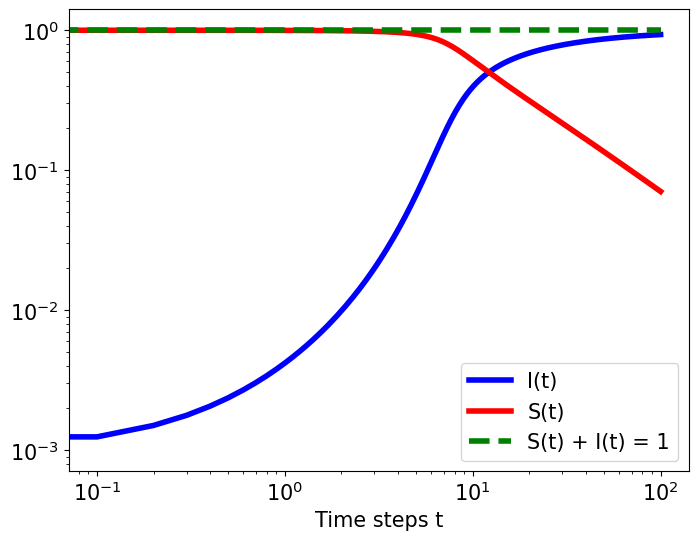

In [19]:
I = infected_from(sol)
S = susceptible_from(sol)

fig, ax = plt.subplots(figsize=(8,6))
plt.loglog(sol.t,I,label="I(t)",color="blue",linewidth=4,linestyle="-")
plt.loglog(sol.t,S,label="S(t)",color="red",linewidth=4,linestyle="-")
plt.loglog(sol.t,I .+ S,label="S(t) + I(t) = 1",color="green",linewidth=4,linestyle="--")
ax.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.xlabel("Time steps t",fontsize=15)

### Advices and further refinements

- To avoid problems, one shoud always choose a $\tau_{\rm max}$ higher than the maximum time of evolution $t_{\rm max}$ to consider all possible states that agents can exhibit.

- The library **_DifferentialEquations.jl_** includes a large number of numerical solvers of differential equations. We used Runge-Kutta solvers but faster solvers may be found for different specific models.